In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.utils import np_utils
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_path='/home/umar/ML-AI/datasets/Face Mask Dataset/Train'
test_path='/home/umar/ML-AI/datasets/Face Mask Dataset/Test'
val_path='/home/umar/ML-AI/datasets/Face Mask Dataset/Validation'

In [4]:
img_size=(256,256)
batch_size=64

datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator=datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

test_generator=datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

val_generator=datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
# We are using InceptionV3 pre-trained model and a fully connected top layer for our classification.

model_pretrained = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(256,256,3))

model=keras.models.Sequential()
model.add(model_pretrained)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation="sigmoid"))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               22118700  
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [7]:
# Time based learning rate scheduling
epoch=50
learning_rate=0.01
decay_rate=learning_rate/epoch
momentum=0.8
sgd=SGD(lr=learning_rate,momentum=momentum,decay=decay_rate)

In [8]:
# Early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [9]:
# compiling the model 
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [10]:
model_history=model.fit(train_generator,epochs=epoch,validation_data=val_generator,shuffle=True, callbacks=[callback])

Epoch 1/50
157/157 [==============================] - 3926s 25s/step - loss: 0.1812 - accuracy: 0.9280 - val_loss: 0.0330 - val_accuracy: 0.9900
Epoch 2/50
157/157 [==============================] - 3567s 23s/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0025 - val_accuracy: 0.9987
Epoch 3/50
157/157 [==============================] - 3570s 23s/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0054 - val_accuracy: 0.9987
Epoch 4/50
157/157 [==============================] - 3484s 22s/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0017 - val_accuracy: 0.9987
Epoch 5/50
157/157 [==============================] - 3483s 22s/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 4.5177e-04 - val_accuracy: 1.0000
Epoch 6/50
157/157 [==============================] - 3480s 22s/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9987
Epoch 7/50
157/157 [==============================] - 3478s 22s/step - loss: 8.3796e-04 - accuracy: 0.9997 - val_loss: 0.0018 

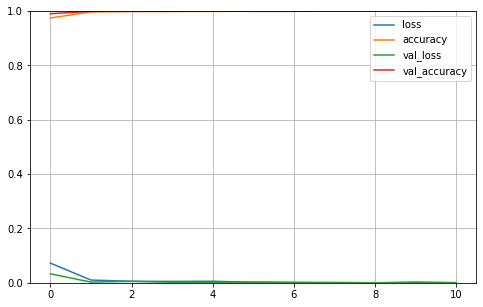

In [11]:
# plotting the varoius metrics
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [12]:
# Testing the model
model.evaluate(test_generator)

16/16 [==============================] - 76s 5s/step - loss: 0.0017 - accuracy: 0.9990


[0.001715083490125835, 0.9989919066429138]

In [13]:
model.save("maskDetect_model")

INFO:tensorflow:Assets written to: maskDetect_model/assets


In [14]:
test_generator.class_indices

{'WithMask': 0, 'WithoutMask': 1}